# Частеречная разметка

Загрузим необходимые библиотеки

In [1]:
import json
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 8.2MB 6.9MB/s 


In [4]:
from pymorphy2 import MorphAnalyzer

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Загрузим корпус

In [6]:
with open('/content/drive/MyDrive/Colab Notebooks/комп линг/corpus_cleared.json', 'r') as corpus_file:
  corpus = json.loads(corpus_file.readline())
corpus['0']

{'comments_ids': [1, 2],
 'comments_number': 2,
 'tags': [],
 'text': 'По просьбам трудящихся организовали паблик анкетных знакомств с той же политикой, что и здесь. До 14-го февраля осталось недолго, но, может, вам удастся найти себе компанию на этот день! ',
 'type': 'post',
 'words_number': 30}

Проведем предобработку: 
* удалим пустые документы
* разделим текст на токены
* переведем их в нижний регистр
* удалим знаки препинания

In [7]:
punct_marks = string.punctuation + "—" + "«" + "»"

In [29]:
corpus_preprocessed = dict()
for doc_id in corpus:
  text = word_tokenize(corpus[doc_id]['text'])
  if not text:
    continue
  text = [token.lower() for token in text if token not in punct_marks]
  corpus_preprocessed[doc_id] = text

In [32]:
corpus_preprocessed['0']

['по',
 'просьбам',
 'трудящихся',
 'организовали',
 'паблик',
 'анкетных',
 'знакомств',
 'с',
 'той',
 'же',
 'политикой',
 'что',
 'и',
 'здесь',
 'до',
 '14-го',
 'февраля',
 'осталось',
 'недолго',
 'но',
 'может',
 'вам',
 'удастся',
 'найти',
 'себе',
 'компанию',
 'на',
 'этот',
 'день']

Создадим частеречную разметку с помощью морфологического анализатора из библиотеки pymorphy2.  
При этом удалим из корпуса стоп-слова - предлоги, союзы, частицы и междометия.

In [10]:
morph = MorphAnalyzer()

In [33]:
for doc_id in corpus_preprocessed:
  text = corpus_preprocessed[doc_id]
  text_tagged = []
  for word in text:
    p = morph.parse(word)[0]
    pos_tag = p.tag.POS
    if pos_tag in ('PREP', 'CONJ', 'PRCL', 'INTJ'):
      continue
    if pos_tag == 'INFN':
      pos_tag = 'VERB'
    text_tagged.append((p.normal_form, pos_tag))
  corpus_preprocessed[doc_id] = text_tagged

In [34]:
corpus_preprocessed['0']

[('просьба', 'NOUN'),
 ('трудящийся', 'ADJF'),
 ('организовать', 'VERB'),
 ('паблик', 'NOUN'),
 ('анкетный', 'ADJF'),
 ('знакомство', 'NOUN'),
 ('тот', 'ADJF'),
 ('политика', 'NOUN'),
 ('здесь', 'ADVB'),
 ('14-й', 'ADJF'),
 ('февраль', 'NOUN'),
 ('остаться', 'VERB'),
 ('недолго', 'ADVB'),
 ('мочь', 'VERB'),
 ('вы', 'NPRO'),
 ('удаться', 'VERB'),
 ('найти', 'VERB'),
 ('себя', 'NPRO'),
 ('компания', 'NOUN'),
 ('этот', 'ADJF'),
 ('день', 'NOUN')]

Посчитаем, сколько раз какая часть речи встретилась в корпусе, и выведем отсортированный список.

In [72]:
pos_count = dict()
for doc_id in corpus_preprocessed:
  text = corpus_preprocessed[doc_id]
  for item in text:
    word, pos_tag = item
    if pos_tag in pos_count:
      pos_count[pos_tag] += 1
    else:
      pos_count[pos_tag] = 1
pos_count = pd.Series(pos_count)
pos_count.sort_values(ascending=False)

NOUN    8301
VERB    6819
ADJF    3786
NPRO    3290
ADVB    3006
NaN      870
PRED     352
COMP     290
ADJS     258
PRTF     117
NUMR      87
GRND      84
PRTS      69
dtype: int64

In [73]:
pos_count.sum()

27329

Посчитаем доли разных частей речи в каждом документе и построим их распределения.  
Для тех частей речи, где это осмысленно, выведем тексты, в которых доля отклоняется от средней больше, чем на два стандартных отклонения.



In [35]:
pos_ratio = {'NOUN': [], 'ADJF': [], 	'ADJS': [], 'COMP': [],
             'VERB': [], 'PRTF': [],	'PRTS': [], 'GRND': [],	
             'NUMR': [],	'ADVB': [], 'NPRO': [],	'PRED': []}
             
for doc_id in corpus_preprocessed:
  text = corpus_preprocessed[doc_id]
  text_pos_count = dict()
  for item in text:
    word, pos_tag = item
    if pos_tag in text_pos_count:
      text_pos_count[pos_tag] += 1
    else:
      text_pos_count[pos_tag] = 1

  text_pos_count = {key: text_pos_count[key] / len(text) 
                    for key in text_pos_count}
  for pos in pos_ratio:
    if pos in text_pos_count:
      pos_ratio[pos].append(text_pos_count[pos])
    else:
      pos_ratio[pos].append(0)

In [36]:
pos_ratio_df = pd.DataFrame(pos_ratio)
pos_ratio_df.head()

,NOUN,ADJF,ADJS,COMP,VERB,PRTF,PRTS,GRND,NUMR,ADVB,NPRO,PRED
0,0.333333,0.238095,0.000000,0.000000,0.238095,0.000000,0.0,0.000000,0.0,0.095238,0.095238,0.0
1,0.407407,0.037037,0.000000,0.037037,0.259259,0.037037,0.0,0.000000,0.0,0.074074,0.148148,0.0
2,0.190476,0.071429,0.000000,0.023810,0.333333,0.000000,0.0,0.000000,0.0,0.166667,0.214286,0.0
3,0.466667,0.200000,0.000000,0.000000,0.133333,0.000000,0.0,0.000000,0.0,0.066667,0.000000,0.0
4,0.260870,0.101449,0.014493,0.014493,0.289855,0.000000,0.0,0.014493,0.0,0.159420,0.130435,0.0


**Существительное**

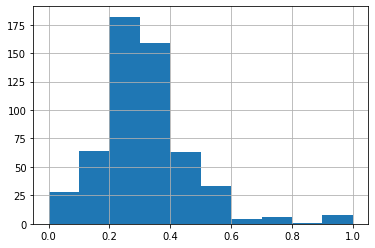

In [64]:
pos_ratio_df['NOUN'].hist();
plt.savefig('noun.jpg')

In [39]:
mean_value = pos_ratio_df['NOUN'].mean()
std_dev = np.std(pos_ratio_df['NOUN'])
print(mean_value, std_dev)
print(mean_value - 2 * std_dev, mean_value + 2 * std_dev)

extra_texts_dict = pos_ratio_df.query(
    'NOUN > @mean_value + 2 * @std_dev | NOUN < @mean_value - 2 * @std_dev')[
    'NOUN'].to_dict()
for key in extra_texts_dict:
  print(str(key) + '. ' + corpus[str(key)]['text'])

0.31347356472215304 0.1551276653967265
0.0032182339287000206 0.6237288955156061
8. Главный вопрос, который у меня возникает, а графический планшет-то есть? На нем надо привыкнуть рисовать и потом становится чуть ли не удобнее чем в традишке. Программа при этом особого значения не имеет, основной функционал у них +- один.
21. всем привет! мне очень нужна ваша помощь для написания курсовой, пишу на тему "эмоциональная сфера ЛГБТ",, внизу будут ссылки на тесты(онлайн), если вам не сложно, пожалуйста, пройдите И ОТПРАВЬТЕ МНЕ СКРИН в лс. Если вы не относитесь к ЛГБТ, то пожалуйста, поделитесь с теми в своем окружении, кто относится. Я буду очень благодарна, помолюсь за вас, можете написать мне, если вам тоже нужна в чем-то помощь, только пройдите, пожалуйста. Я подобную аудиторию могу собрать только в интернете, к сожалению:( лайкните, пожалуйста, или оставьте коммент, чтобы высветилось в ленте:) 1) опросник басса и дарки на враждебность\агрессивность() 2)шкала депрессии Бека() 3) шкала тр

**Глагол**

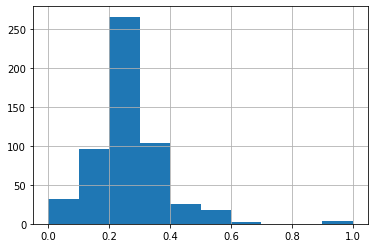

In [65]:
pos_ratio_df['VERB'].hist();
plt.savefig('verb.jpg')

In [40]:
mean_value = pos_ratio_df['VERB'].mean()
std_dev = np.std(pos_ratio_df['VERB'])
print(mean_value, std_dev)
print(mean_value - 2 * std_dev, mean_value + 2 * std_dev)

extra_texts_dict = pos_ratio_df.query(
    'VERB >= @mean_value + 2 * @std_dev | VERB <= @mean_value - 2 * @std_dev')[
    'VERB'].to_dict()
for key in extra_texts_dict:
  print(str(key) + '. ' + corpus[str(key)]['text'])

0.26245236866087446 0.1229300283320272
0.01659231199682007 0.5083124253249288
8. Главный вопрос, который у меня возникает, а графический планшет-то есть? На нем надо привыкнуть рисовать и потом становится чуть ли не удобнее чем в традишке. Программа при этом особого значения не имеет, основной функционал у них +- один.
21. всем привет! мне очень нужна ваша помощь для написания курсовой, пишу на тему "эмоциональная сфера ЛГБТ",, внизу будут ссылки на тесты(онлайн), если вам не сложно, пожалуйста, пройдите И ОТПРАВЬТЕ МНЕ СКРИН в лс. Если вы не относитесь к ЛГБТ, то пожалуйста, поделитесь с теми в своем окружении, кто относится. Я буду очень благодарна, помолюсь за вас, можете написать мне, если вам тоже нужна в чем-то помощь, только пройдите, пожалуйста. Я подобную аудиторию могу собрать только в интернете, к сожалению:( лайкните, пожалуйста, или оставьте коммент, чтобы высветилось в ленте:) 1) опросник басса и дарки на враждебность\агрессивность() 2)шкала депрессии Бека() 3) шкала трев

**Прилагательное (полное)**

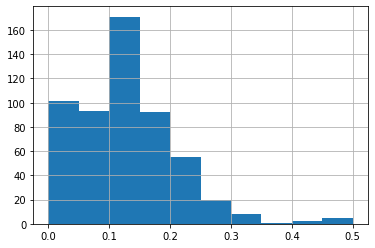

In [66]:
pos_ratio_df['ADJF'].hist();
plt.savefig('adjf.jpg')

In [41]:
mean_value = pos_ratio_df['ADJF'].mean()
std_dev = np.std(pos_ratio_df['ADJF'])
print(mean_value, std_dev)
print(mean_value - 2 * std_dev, mean_value + 2 * std_dev)

extra_texts_dict = pos_ratio_df.query(
    'ADJF >= @mean_value + 2 * @std_dev | ADJF <= @mean_value - 2 * @std_dev')[
    'ADJF'].to_dict()
for key in extra_texts_dict:
  print(str(key) + '. ' + corpus[str(key)]['text'])

0.12477957946682847 0.08619082380652973
-0.047602068146231 0.2971612270798879
30. Поддержка Вам. Жить одному в квартире, где раньше счастливо жили с любимым человеком - знакомо. Очень всё напоминает. Надеюсь, вы сможете съехать, как можно быстрее.
131. Тоже думаю, что это даже мило. Значит, настоящие чувства испытываете, боитесь "не в лучшем" свете перед человеком показаться, хотите быть хорошими друг для друга. Прелесть какая. Я бы на самом деле пустил такое на самотёк. Пусть бы такие заигрывания имели место в жизни. К чему-то большему никогда не поздно прийти, а этих эмоций можно и не найти потом уже. Наслаждайтесь и будьте счастливы :)
193. Вы уже на финальном пути, может занять денег на обучение у кого-то из родственников или друзей?
199. Способ с записью экрана не работает :(
212. Бывают ситуации, когда как раз психиатр и помог бы все хоть немного наладить. И в этом нет ничего такого, бояться туда идти - еще больше усугублять проблему Если есть деньги, можно попробовать платного, 

**Наречие**

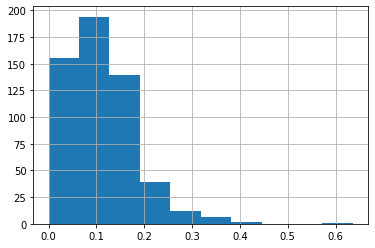

In [49]:
pos_ratio_df['ADVB'].hist();

In [52]:
mean_value = pos_ratio_df['ADVB'].mean()
std_dev = np.std(pos_ratio_df['ADVB'])
print(mean_value, std_dev)
print(mean_value - 2 * std_dev, mean_value + 2 * std_dev)

extra_texts_dict = pos_ratio_df.query(
    'ADVB >= @mean_value + 2 * @std_dev | ADVB <= @mean_value - 2 * @std_dev')[
    'ADVB'].to_dict()
for key in extra_texts_dict:
  print(str(key) + '. ' + corpus[str(key)]['text'])

0.10643859724582592 0.07951952475753395
-0.05260045226924197 0.2654776467608938
59. Из учебника "Акушерство" Во время беременности в организме женщины происходят существенные изменения, касающиеся практически всех систем организма. Изменения психологического состояния проявляются в виде эмоциональных ощущений: раздражительность, депрессия и др. На развитие психологических нарушений во время беременности влияют следующие факторы: гормональные и физиологические изменения; личные свойства; социально-экономический статус; отношение в семье; нерешенные конфликты; генетическая предрасположенность (например, депрессии) физические и психические заболевания; употребление алкоголя и наркотиков. Эмоциональные и физические ощущения будущих матерей врачам необходимо учитывать при надзоре за ходом беременности, в родах и в послеродовом периоде. Во время беременности довольно часто возникают типичные дискомфортные состояния, не имеющие серьезных последствий, но приводят к значительному дискомфорта и 

**Личное местоимение**

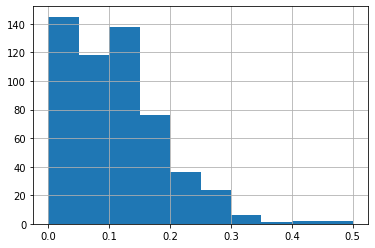

In [53]:
pos_ratio_df['NPRO'].hist();

In [54]:
mean_value = pos_ratio_df['NPRO'].mean()
std_dev = np.std(pos_ratio_df['NPRO'])
print(mean_value, std_dev)
print(mean_value - 2 * std_dev, mean_value + 2 * std_dev)

extra_texts_dict = pos_ratio_df.query(
    'NPRO >= @mean_value + 2 * @std_dev | NPRO <= @mean_value - 2 * @std_dev')[
    'NPRO'].to_dict()
for key in extra_texts_dict:
  print(str(key) + '. ' + corpus[str(key)]['text'])

0.10719652071956366 0.08345310317619269
-0.05970968563282171 0.27410272707194905
14.  Анонимно, опубликуйте, пожалуйста. Такая ситуация. Есть у меня подруга и общаемся мы с ней уже лет десять и мне в принципе неплохо с ней дружить. У неё появился парень (уже пару лет). Сначала, я с ними просто нормально общалась, ездила к ним в гости. Ровно два раза я переспала с этим парнем (с одобрения подруги). Странно, что я её потом спросила, нормально ли такое вообще. И она мне ответила, что нормально всё. Мы до сих пор общаемся с ней. Месяца три назад, у меня начались серьёзные проблемы со здоровьем. Так совпало, что второй раз, когда у меня была встреча (свидание, секс) с парнем подруги, пришёлся на эту плохую ситуацию со здоровьем и финансами. Нужно подчеркнуть, что подруга была в курсе, где и с кем парень (даже смс нам вечером писала и говорила, что сама или не может или не хочет к нам приехать). Я из-за доверительной атмосферы, рассказала о своих проблемах парню. Он меня спросил что-то вроде

**Прилагательное (краткое)** и **компаратив**

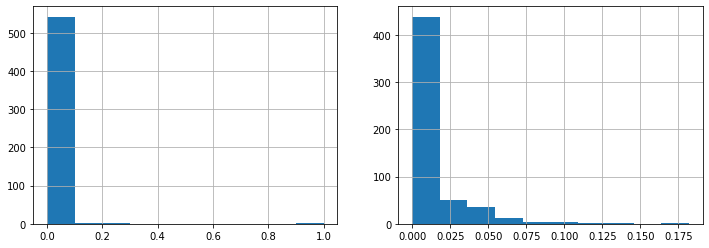

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2)
pos_ratio_df['ADJS'].hist(ax=axes[0], figsize=(12, 4));
pos_ratio_df['COMP'].hist(ax=axes[1], figsize=(12, 4));

**Причастие (полное и краткое)**

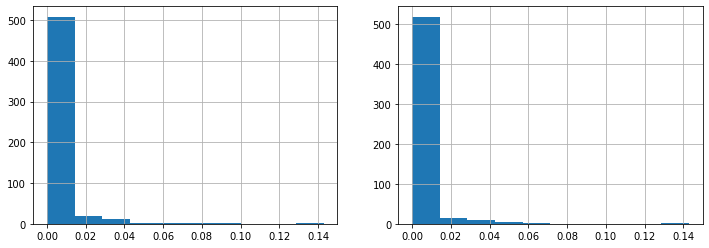

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2)
pos_ratio_df['PRTF'].hist(ax=axes[0], figsize=(12, 4));
pos_ratio_df['PRTS'].hist(ax=axes[1], figsize=(12, 4));

**Деепричастие**, **числительное** и **предикатив**

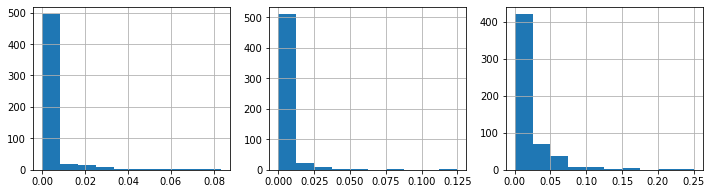

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=3)
pos_ratio_df['GRND'].hist(ax=axes[0], figsize=(12, 3));
pos_ratio_df['NUMR'].hist(ax=axes[1], figsize=(12, 3));
pos_ratio_df['PRED'].hist(ax=axes[2], figsize=(12, 3));